In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bintrees as bt

In [2]:
#determinant test; return 1 if r is left of line pq, -1 if r right of line pq, 0 if on line pq
def detTest(px,py,qx,qy,rx,ry):
    D=np.array([[1,px,py],[1,qx,qy],[1,rx,ry]],dtype='i8')
    return int(np.sign(np.linalg.det(D)))
    
#returns true iff pq and rs cross
def cross(px,py,qx,qy,rx,ry,sx,sy):
    pqr=detTest(px,py,qx,qy,rx,ry)
    pqs=detTest(px,py,qx,qy,sx,sy)
    if not ((pqr==1 and pqs==-1) or (pqr==-1 and pqs==1)):
        return False
    rsp=detTest(rx,ry,sx,sy,px,py)
    rsq=detTest(rx,ry,sx,sy,qx,qy)
    if not ((rsp==1 and rsq==-1) or (rsp==-1 and rsq==1)):
        return False
    return True

In [1]:
#classes for points and segments
class Point:
    def __init__(self, x, y):
        self.x=x
        self.y=y
    def plot(self):
        plt.scatter(self.x,self.y)    
            
    def __lt__(self,other):
        return self.x<other.x or (self.x==other.x and self.y<other.y)        
    def __gt__(self,other):
        return self.x>other.x or (self.x==other.x and self.y>other.y)    
    def __eq__(self,other):
        return self.x==other.x and self.y==other.y    
    def __le__(self,other):
        return self.x<other.x or (self.x==other.x and self.y<=other.y)    
    def __ge__(self,other):
        return self.x>other.x or (self.x==other.x and self.y>=other.y)   
    def __ne__(self,other):
        return not (self==other)

#color is 0 for red, 1 for blue
class Segment:
    def __init__(self,pointA,pointB,color):
        if pointA<pointB:
            self.p=pointA
            self.q=pointB
        else:
            self.p=pointB
            self.q=pointA
        self.color=color
    
    def cmp(self,p):
        return detTest(self.p.x,self.p.y,self.q.x,self.q.y,p.x,p.y)
    
    def cross(self,segB):
        return cross(self.p.x,self.p.y,self.q.x,self.q.y,segB.p.x,segB.p.y,segB.q.x,segB.q.y)
    
    def col(self,seg):
        if self.cmp(seg.p)==0 and self.cmp(seg.q)==0:
            return True
        else:
            return False
    def slope(self):
        if (self.q.x-self.p.x)==0:
            return float('inf')
        else:
            return (self.q.y-self.p.y)/(self.q.x-self.p.x)
    def plot(self):
        if self.color==0:
            plt.plot([self.p.x,self.q.x],[self.p.y,self.q.y],'r')
        else:
            plt.plot([self.p.x,self.q.x],[self.p.y,self.q.y],'b')
            

    #ordered by aboveness (no intersections)
    #red below blue if the segments overlap
    def __lt__(self,other):
        return (other.cmp(self.p)==-1 or self.cmp(other.p)==1) or (self.p==other.p and self.q==other.q and self.color<other.color)
    def __gt__(self,other):
        return (other.cmp(self.p)==1 or self.cmp(other.p)==-1) or (self.p==other.p and self.q==other.q and self.color>other.color)
    def __eq__(self,other):
        return (self.p==other.p and self.q==other.q and self.color==other.color) or (self.p==self.q and other.cmp(self.p)==0) or (other.p==other.q and self.cmp(other.p)==0)
    def __le__(self,other):
        return self<other or self==other
    def __ge__(self,other):
        return self>other or self==other
    def __ne__(self,other):
        return not self==other
    
            

#flags are made from a segment and a endpoint of the segment
#0 is for startpt, 1 is for endpt
class Flag:
    def __init__(self, segment, endpoint):
        self.seg=segment
        self.pt=endpoint
        if self.pt==self.seg.p:
            self.type=0
        elif self.pt==self.seg.q:
            self.type=1
        else:
            raise NameError('point is not an endpoint of segment')    
        sa=None
        sb=None
        oa=None
        ob=None
        
    def cmp(self, flagB):
        if self.pt<(flagB.pt):
            return -1
        elif self.pt>(flagB.pt):
            return 1
        else:
            if self.type==1 and flagB.type==0:
                return -1
            elif self.type==0 and flagB.type==1:
                return 1
            else:
                if self.seg.slope()<flagB.seg.slope():
                    return -1
                elif self.seg.slope()>flagB.seg.slope():
                    return 1
                else:
                    if self.type==1:
                        if self.seg.color==0 and flagB.seg.color==1:
                            return -1
                        elif self.seg.color==1 and flagB.seg.color==0:
                            return 1
                        else:
                            return 0
                    else:
                        if self.seg.color==1 and flagB.seg.color==0:
                            return -1
                        elif self.seg.color==0 and flagB.seg.color==1:
                            return 1
                        else:
                            return 0
    def __lt__(self,other):
        self.cmp(other)<0
    def __gt__(self,other):
        self.cmp(other)>0
    def __eq__(self,other):
        self.cmp(other)==0
    def __le__(self,other):
        self.cmp(other)<=0
    def __ge__(self,other):
        self.cmp(other)>=0
    def __ne__(self,other):
        self.cmp(other)!=0

In [2]:
#for building segments
class AllSegments:
    def __init__(self):
        self.red=[]
        self.blue=[]
        self.sortedFlags=[]
    #adding segments 
    def addRed(self,px,py,qx,qy):
        self.red.append(Segment(Point(px,py),Point(qx,qy),0))
    def addBlue(self,px,py,qx,qy):
        self.blue.append(Segment(Point(px,py),Point(qx,qy),1))
    
    #create square with endpts (-x,-x), (-x,x), (x,-x), (x,x)
    def addRedSq(self,x):
        self.addRed(-x,-x,-x,x)
        self.addRed(-x,-x,x,-x)
        self.addRed(x,x,x,-x)
        self.addRed(x,x,-x,x)
    
    #return the sorted list of flags
    def sortFlags(self):
        flags=[]
        for i in range(len(self.red)):
            flags.append(Flag(self.red[i],self.red[i].p))
            flags.append(Flag(self.red[i],self.red[i].q))
        for i in range(len(self.blue)):
            flags.append(Flag(self.blue[i],self.blue[i].p))
            flags.append(Flag(self.blue[i],self.blue[i].q))
        self.sortedFlags=sorted(flags)
    
    #plot all the segments
    def plot(self):
        for i in range(len(self.red)):
            self.red[i].plot()
            print((self.red[i].p.x,self.red[i].p.y), (self.red[i].q.x,self.red[i].q.y), 'red')
        for i in range(len(self.blue)):
            self.blue[i].plot()
            print((self.blue[i].p.x,self.blue[i].p.y), (self.blue[i].q.x,self.blue[i].q.y), 'blue')
        plt.axis('equal')
        plt.show()

In [5]:
class Bundle():
    def __init__(self,color):
        self.segs=bt.RBTree()       
        self.color=color
        self.below=None
        self.above=None
    def top(self):
        return self.segs.max_item()[0]
    def bottom(self):
        return self.segs.min_item()[0]
    def insert(seg):
        if seg.color!=self.color:
            raise NameError('color does not match for this bundle')
        else:
            self.segs.insert(seg,0)
    def remove(seg):
        self.segs.remove(seg)
    
    def nextItem(seg):
        return self.segs.succ_item(seg)
        
    def pointTest(point):
        pt=Segment(point,point,color)
        self.insert(pt)
        above=self.segs.succ_item(pt)[0]
        self.remove(pt)
        return above
        
    #for inserting/deleting bundles in rbtree
    def __lt__(self,other):
        return self.top()<other.bottom()
    def __gt__(self,other):
        return self.bottom()>other.top()
    def __eq__(self,other):
        return self.bottom()==other.bottom() and self.top()==other.top()
    def __le__(self,other):
        return self<other or self==other
    def __ge__(self,other):
        return self>other or self==other
        
#Bundle tree only holds red segments
class BundleTree():
    def __init__(self):
        self.redBund=bt.RBTree()
        self.intersections=[]

    def findHelper(self,bundle,pt):
        if pt>bundle.above.bottom():
            self.findHelper(self,bundle.right,seg)
        elif pt<=bundle.below.bottom():
            self.findHelper(self,bundle.left,seg)
        else:
            return bundle

    def findBundle(self,point):
        pt=Segment(point,point,1)
        return self.findHelper(self.redBund.root,pt)
        
    def split(self,bund,point):
        pt=Segment(point,point,bund.color)
        above=bund.pointTest(pt)
        split=Bundle(bund.color)
        top=bund.top()
        if above==None:
            return
        while top!=above:
            split.insert(top)
            bund.remove(top)
            top=bund.top()
        split.insert(top)
        bund.remove(top)
        split.above=bund.above
        split.below=bund
        bund.above=split
        self.redBund.insert(split,0)
        
    def merge(self,bund1,bund2):
        if bund1.color != bund2.color:
            return
        seg=bund2.bottom()
        top=bund2.top()
        while seg!=top:
            bund1.insert(seg)
            seg=bund2.nextItem(seg)
        bund1.insert(top)
        if bund1.top()<bund2.bottom():
            bund1.above=bund2.above
        else:
            bund1.below=bund2.below
        self.redBundle.remove(bund2)
        
    def swapMerge(self,bund,direction): #only does merge if colors agree
        bundAbv=bund.above
        bundBel=bund.below
        if direction==1:
            bund.above=bundAbv.above
            bund.below=bundAbv
            bundAbv.above=bund
            bundAbv.below=bundBel
            self.merge(bund,bund.above)
            self.merge(bund.below,bund.below.below)
        else:
            bund.above=bundBel
            bund.below=bundBel.below
            bundBel.above=bundAbv
            bundBel.below=bund
            self.merge(bund,bund.below)
            self.merge(bund.above,bund.above.above)
    
    def processPoint(self,point):
        bund=findBundle(point)
        pt=Segment(point,point,1)
        bab=bund.above.bottom
        bbt=bund.below.top
        if pt<=bab and pt>bbt:
            return bund
        elif pt>bab:
            self.split(bund,point)
            bund=bund.above
            while pt>bund.above.top:
                self.swapMerge(bund,1)
            if pt<bund.above.bot:
                return bund
            else:
                self.split(bund.above,point)
                self.swapMerge(bund,1)
                return bund
        else:
            self.split(bund,point)
            while pt<bund.below,bottom:
                self.swapMerge(bund,0)
            if pt>bund.below.toop:
                return bund
            else:
                self.split(bund.below,point)
                self.swapMerge(bund,0)
                return bund

    def insertSeg(self,seg):
        point=seg.p
        bund=self.processPoint(point)
        bund.insert(seg)
    
    def deleteSeg(self,seg):
        point=seg.q
        bund=findBundle(point)
        bund.remove(seg)
        self.process(point)

In [7]:
a=AllSegments()
a.addRedSq(5)

(-5, -5) (-5, 5) red
(-5, -5) (5, -5) red
(5, -5) (5, 5) red
(-5, 5) (5, 5) red


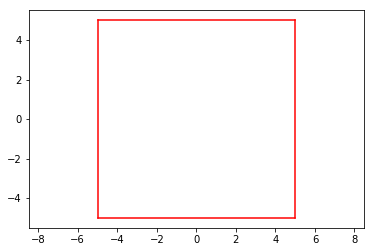

In [8]:
a.plot()